In [1]:
import os
from os import environ
import sys
import io
from os.path import expanduser
sys.path.append("../model/robosat_pink/")

from importlib import import_module
import pkgutil

import boto3
import s3fs

import ipywidgets as widgets

from re import match 
from tqdm import tqdm_notebook

import sklearn

from numpy.random import randint
import numpy as np

import robosat_pink.losses
import robosat_pink.models
from robosat_pink.datasets import MultiSlippyMapTilesConcatenation
from robosat_pink.tools.train import get_dataset_loaders
from robosat_pink.config import load_config
from robosat_pink.logs import Logs
from robosat_pink.metrics import Metrics

import skimage

import torch
import torch.backends.cudnn
from torch.optim import Adam
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

# Experiment with Trained Model
as follows:


In [4]:
fs = s3fs.S3FileSystem(session = boto3.Session(profile_name='esip'))
models = fs.walk("planet-snowcover-models")
ans = widgets.Select(options=models, layout = {'width': "500px"})
ans

Select(layout=Layout(width='500px'), options=('planet-snowcover-models/checkpoint-16-may-all.pth', 'planet-sno…

In [5]:
models

['planet-snowcover-models/checkpoint-16-may-all.pth',
 'planet-snowcover-models/checkpoint-190319-18:52:42',
 'planet-snowcover-models/checkpoint-190319-20:47:57',
 'planet-snowcover-models/checkpoint-190319-22:08:56',
 'planet-snowcover-models/checkpoint-190404-23:24:15',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00001-of-00010.pth',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00002-of-00010.pth',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00003-of-00010.pth',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00004-of-00010.pth',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00005-of-00010.pth',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00006-of-00010.pth',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00007-of-00010.pth',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00008-of-00010.pth',
 'planet-snowcover-models/05-02-19-checkpoints/checkpoint-00009-of-00010.pth',
 'planet-snowco

In [18]:
path = ans.value
path = "planet-snowcover-models/USCOGE-20180524-may16ckpt/checkpoint-00050-of-00050.pth"
trainedModel = "s3://" + path
print(trainedModel)

s3://planet-snowcover-models/USCOGE-20180524-may16ckpt/checkpoint-00050-of-00050.pth


In [19]:
# trainedModel = "s3://planet-snowcover-models/checkpoint-190319-20:47:57"
# trainedModel = "s3://planet-snowcover-models/checkpoint-16-may-all.pth"
# modelConfig = '../experiments/ASO_3M_SD_USCOGE_20180524.toml'
modelConfig = '../experiments/tester-harnes.toml'

S3_CHECKPOINT = False
if trainedModel.startswith("s3://"):
    S3_CHECKPOINT = True
    # load from s3 
    
    trainedModel = trainedModel[5:]
    sess = boto3.Session(profile_name='esip')
    fs = s3fs.S3FileSystem(session=sess)
    s3ckpt = s3fs.S3File(fs, trainedModel, 'rb')
    


## Build Network

In [20]:
config = load_config(modelConfig)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")


num_classes = len(config["classes"])
num_channels = 0
for channel in config["channels"]:
    num_channels += len(channel["bands"])
pretrained = config["model"]["pretrained"]
encoder = config["model"]["encoder"]

models = [name for _, name, _ in pkgutil.iter_modules([os.path.dirname(robosat_pink.models.__file__)])]
if config["model"]["name"] not in [model for model in models]:
    sys.exit("Unknown model, thoses available are {}".format([model for model in models]))

model_module = import_module("robosat_pink.models.{}".format(config["model"]["name"]))
net = getattr(model_module, "{}".format(config["model"]["name"].title()))(
    num_classes=num_classes, num_channels=num_channels, encoder=encoder, pretrained=pretrained
).to(device)

net = torch.nn.DataParallel(net)
optimizer = Adam(net.parameters(), lr=config["model"]["lr"], weight_decay=config["model"]["decay"])


## Load Checkpoint

In [21]:

def map_location(storage, _):
    return storage.cuda() if torch.cuda.is_available() else storage.cpu()
try: 
    if S3_CHECKPOINT:
        with s3fs.S3File(fs, trainedModel, 'rb') as C:
            state = torch.load(io.BytesIO(C.read()), map_location = map_location)
    else: 
        state = torch.load(trainedModel, map_location= map_location)
    optimizer.load_state_dict(state['optimizer'])
    net.load_state_dict(state['state_dict'])
    net.to(device)
except FileNotFoundError as f:
    print("{} checkpoint not found.".format(CHECKPOINT))

losses = [name for _, name, _ in pkgutil.iter_modules([os.path.dirname(robosat_pink.losses.__file__)])]
if config["model"]["loss"] not in [loss for loss in losses]:
    sys.exit("Unknown loss, thoses available are {}".format([loss for loss in losses]))

loss_module = import_module("robosat_pink.losses.{}".format(config["model"]["loss"]))
criterion = getattr(loss_module, "{}".format(config["model"]["loss"].title()))().to(device)

## Load Imagery

In [7]:
fs = s3fs.S3FileSystem(session = boto3.Session(profile_name = config['dataset']['aws_profile']))

imagery_searchpath = config['dataset']['image_bucket']  + '/' +  config['dataset']['imagery_directory_regex']
print("Searching for imagery...({})".format(imagery_searchpath))
imagery_candidates = fs.ls(config['dataset']['image_bucket'])
print("candidates:")
print(imagery_candidates)
imagery_locs = [c for c in imagery_candidates if match(imagery_searchpath, c)]
print("result:")
print(imagery_locs)

mask_searchpath = config['dataset']['mask_bucket'] + '/' +  config['dataset']['mask_directory_regex']
print("Searching for mask...({})".format(mask_searchpath))
mask_candidates = fs.ls(config['dataset']['mask_bucket'])
print("candidates:")
print(mask_candidates)
mask_locs = [c for c in mask_candidates if match(mask_searchpath, c)]
print("result:")
print(mask_locs)

assert(len(mask_locs) > 0 and len(imagery_locs) > 0)

print("Merging tilesets...")

allTiles = MultiSlippyMapTilesConcatenation(imagery_locs, mask_locs, aws_profile = config['dataset']['aws_profile'])

Searching for imagery...(planet-snowcover-imagery/20180524_.*)
candidates:
['planet-snowcover-imagery/20180423_180737_1009_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_SR_clip.tif', 'planet-snowcover-imagery/20180601_181447_0f32_3B_AnalyticMS_metadata_clip.xml', 'planet-snowcover-imagery/20180601_181447_0f32_metadata.json', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_SR_clip.tif', 'planet-snowcover-imagery/20180601_181448_0f32_3B_AnalyticMS_metadata_clip.xml', 'planet-snowcover-imagery/20180601_181448_0f32_metadata.json', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_DN_udm_clip.tif', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_SR_clip_scaled.tif', 'planet-snowcover-imagery/20180601_181449_0f32_3B_AnalyticMS_metadata_clip.xml', 'planet

In [8]:
len(allTiles)

1204

## Test

In [9]:
limit = 8
images, masks, tiles = [], [], []
idxs = randint(0, len(allTiles), size=limit)
for i in idxs:
    i, m, t = allTiles[i]
    print(t)
    images.append(i)
    masks.append(m)
    tiles.append(t)

    
imageTensor = torch.from_numpy(np.stack(images))

planet-snowcover-imagery_20180524_172633_0f2d_3B_AnalyticMS_SR_clip-6639-12549-15
planet-snowcover-imagery_20180524_172146_103d_3B_AnalyticMS_SR_clip-6637-12543-15
planet-snowcover-imagery_20180524_172634_0f2d_3B_AnalyticMS_SR_clip-6639-12538-15
planet-snowcover-imagery_20180524_172637_0f2d_3B_AnalyticMS_SR_clip-6634-12514-15
planet-snowcover-imagery_20180524_172635_0f2d_3B_AnalyticMS_SR_clip-6639-12527-15
planet-snowcover-imagery_20180524_172634_0f2d_3B_AnalyticMS_SR_clip-6650-12535-15
planet-snowcover-imagery_20180524_172635_0f2d_3B_AnalyticMS_SR_clip-6631-12530-15
planet-snowcover-imagery_20180524_172143_103d_3B_AnalyticMS_SR_clip-6658-12525-15


In [10]:
masks = np.stack(masks)
masks.shape

(8, 512, 512)

In [11]:
net.eval()
with torch.no_grad():
    raw = net(imageTensor)

In [12]:
metrics = Metrics()
for mask, output in zip(masks, raw):
    metrics.add(torch.Tensor(mask), output.cpu() , is_prob=True)

In [13]:
print(sklearn.metrics.precision_recall_fscore_support(np.round(masks.flatten()), (raw > 0).flatten().cpu().numpy(), average='binary'))

(0.5554807796464073, 0.7721538047517749, 0.6461365235749472, None)


In [14]:
metrics.get_classification_stats()

{'accuracy': 0.8741192817687988,
 'precision': 0.7721538047517749,
 'recall': 0.13147617694245078,
 'f1': 0.2246933641355952}

In [21]:
def plot3(image, mask, pred, tile, ax = None):
#     fig.suptitle(tile)
    ax[0].imshow(image)
#     ax[0].set_title(tile)
    ax[1].imshow(mask)
#     ax[1].set_title("mask")
    ax[2].imshow(pred > 0.0, cmap='cividis')#, vmin = 0, vmax = )
#     ax[2].set_title('prediction')
#     ax[3].imshow((pred > 0.0) - mask, cmap='seismic')
    mets = sklearn.metrics.precision_recall_fscore_support(np.round(mask.flatten()), 
                                                          (pred > 0).flatten().astype(int), average='binary')
#     ax[2].set_title(mets)
        
    print(mets)
    return(mets)

#     plt.colorbar(diff, ax = ax[3])
    # NDSI = 1-4 / 1 + 4
#    plt.colorbar(pred, ax  = ax[2], orientation='horizontal')


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))


(0.0, 0.0, 0.0, 0)
(0.28021846116912735, 0.3729531112708683, 0.3200027415098866, None)
(0.115, 0.016405135520684736, 0.028714107365792756, None)
(0.7131221855073767, 0.7960021745494082, 0.7522863263063875, None)
(0.1930547792062605, 0.42790769707294407, 0.2660696229958111, None)
(0.23412874857961563, 0.6232656013677912, 0.34039038230171126, None)
(0.5809329982901723, 0.8566426785076303, 0.6923489423489424, None)
(0.5335950565156026, 0.7622541129428508, 0.6277505686020064, None)


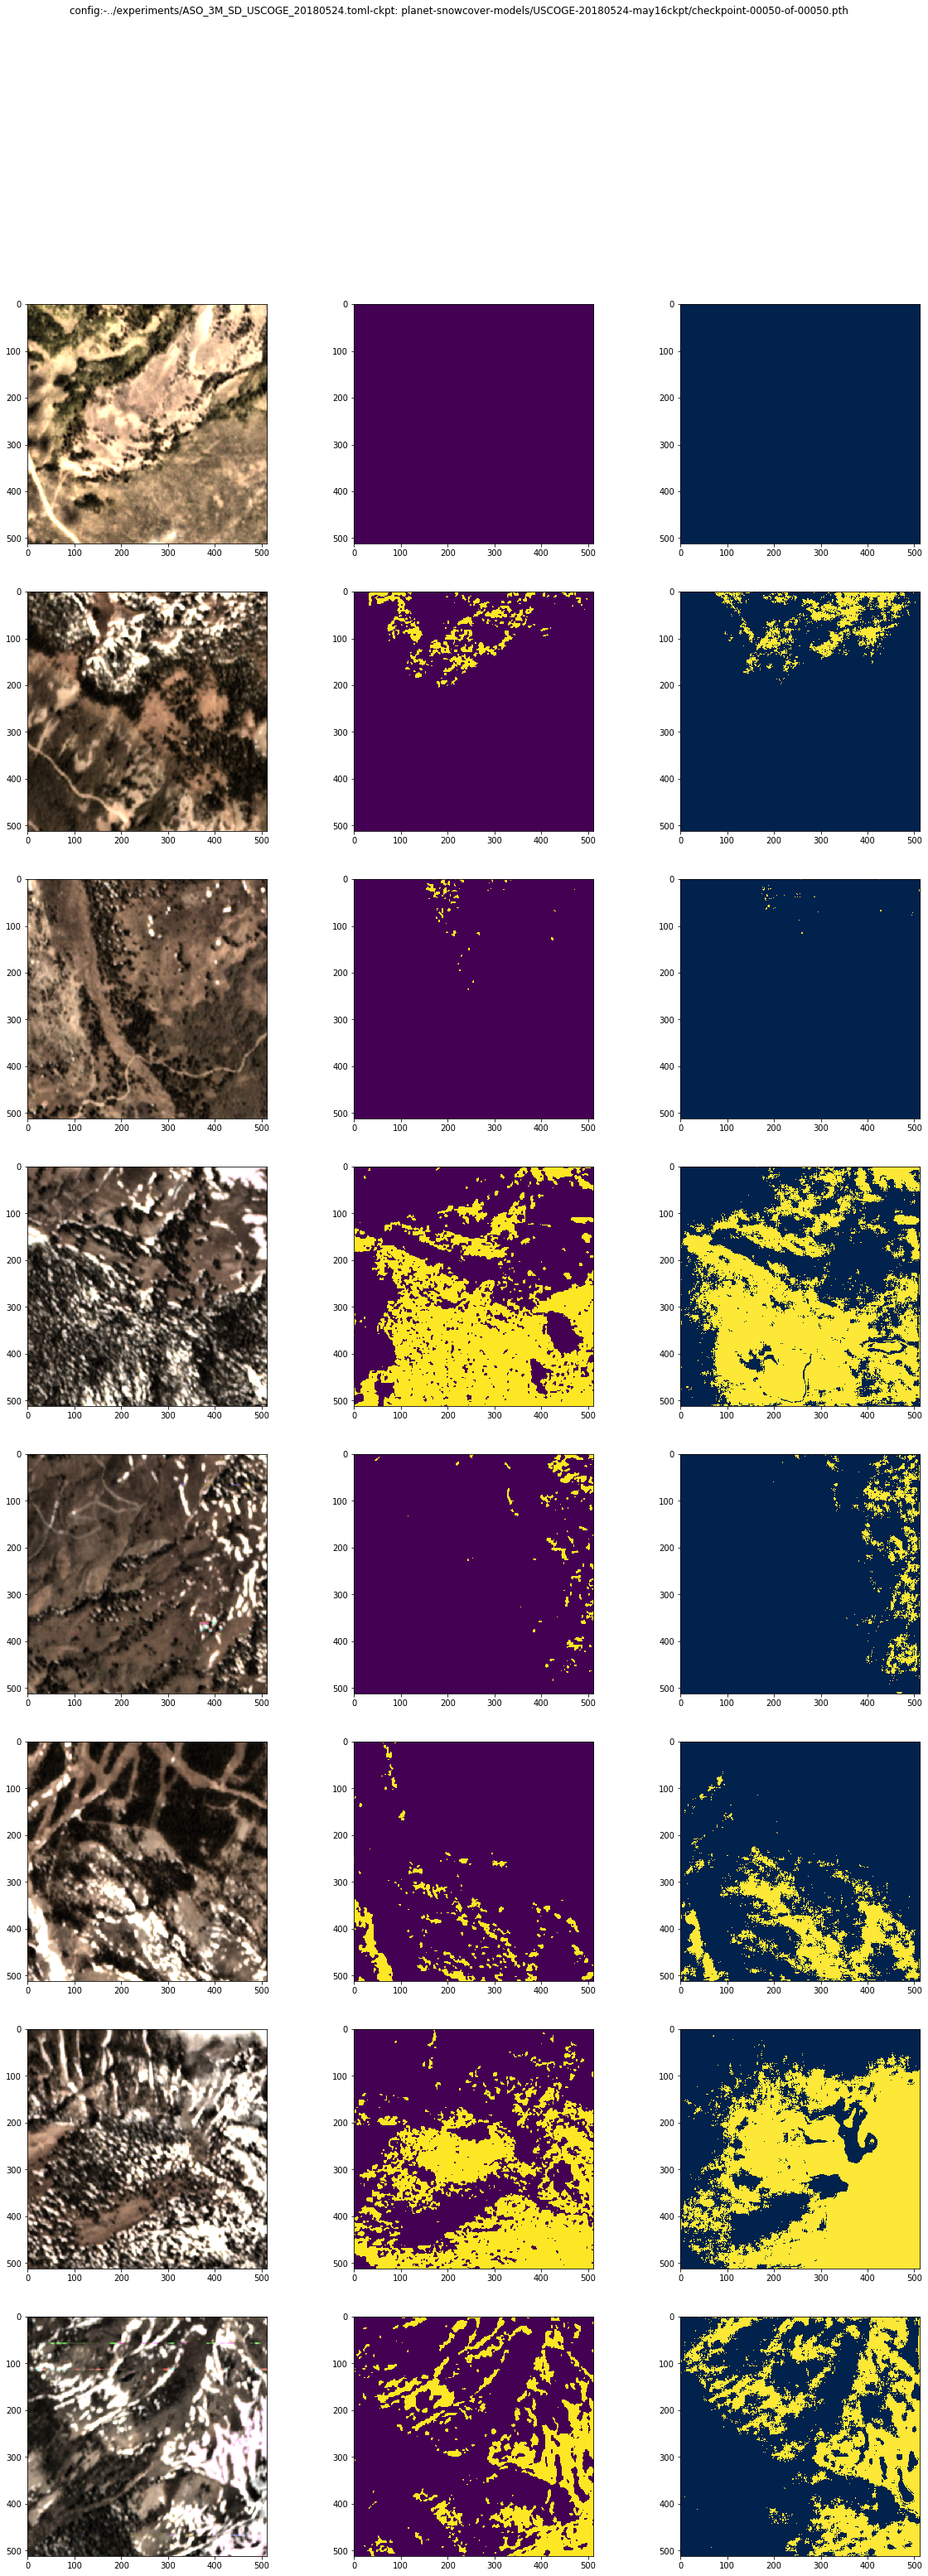

In [22]:
fig, ax = plt.subplots(raw.shape[0], 3, figsize=(20, 50))
mets = []
for image in range(raw.shape[0]):
    imageTensor = imageTensor.cpu()
    raw = raw.cpu()
    rgb = np.moveaxis(imageTensor[image, [2, 1, 0], :, :].numpy(), 0, 2)
    rgb = skimage.exposure.rescale_intensity(skimage.exposure.equalize_adapthist(rgb), in_range = (0, .62))
    met = plot3(rgb, masks[image, :, :],  (raw[image]).cpu().numpy().squeeze()  , tiles[image], ax = ax[image])
    if met[0] != 0:
        mets.append(met)
#    plot3(s[0][image, 3, :, :], s[1][image, :, :],  torch.nn.functional.softmax(raw[image].squeeze(), dim=0).data.cpu().numpy())
fig.suptitle("config:-{}-ckpt: {}".format(modelConfig, trainedModel))
imgfname = "config: {} ckpt: {}".format(modelConfig, trainedModel).replace('/', '-').replace('.', '-')
plt.savefig(imgfname+".png", transparent=True)

---

In [11]:
import sklearn

In [47]:
from sklearn.metrics import roc_curve, auc


(0.6271956390066626, 0.9375168228644138, 0.7515840477077897, None)


In [14]:

fpr, tpr, thresholds = sklearn.metrics.roc_curve(np.round(masks.flatten()), (raw > 0).flatten().numpy())
roc_auc = sklearn.metrics.auc(fpr, tpr)
print("\n Area under the ROC curve : %f" % roc_auc)


 Area under the ROC curve : 0.872022


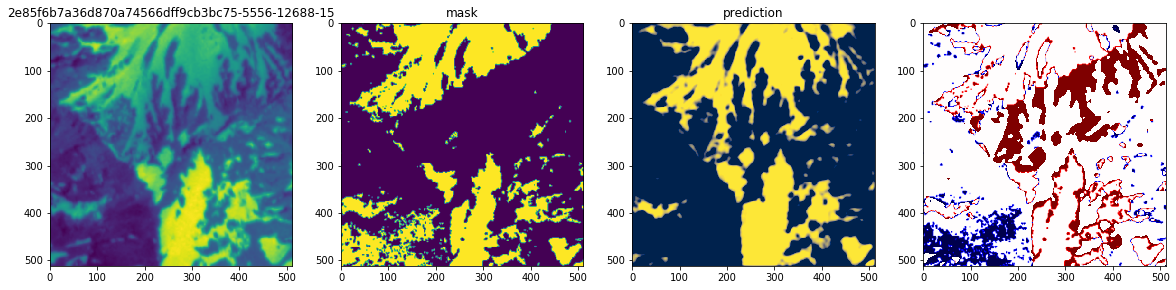

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
plot3(imageTensor[3, 3, :, :], masks[3, :, :],  (raw[3]).detach().numpy().squeeze()  , tiles[3], ax = ax)
                       
plt.savefig("../artifacts/figures/lowelev.png", bbox_inches='tight', dpi=300)


In [62]:
(rgb > 1).any()

False

In [14]:
loader = DataLoader(allTiles,
                    batch_size = 7 , 
                    shuffle = True,
                    num_workers = 1)

In [17]:
batchStats = []

net.eval()

for images, masks, _tiles in tqdm_notebook(loader, desc="Predict", unit="batch", ascii=True):

    with torch.no_grad():
        raw = net(images)

    for raw_prob, mask in zip(raw, masks):
        prob = raw_prob > 0 
        print(np.mean(prob.flatten().cpu().numpy()))
        stats = sklearn.metrics.precision_recall_fscore_support(
                    np.round(mask.flatten().cpu().numpy()),
                    prob.flatten().cpu().numpy(), average='binary')
        batchStats.append(stats)
        
        

        


0.0
0.8111953735351562
0.13071060180664062
0.0
0.7006950378417969
0.0
0.0


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0
0.312835693359375
0.04695892333984375
0.48856353759765625
0.0
0.5528373718261719
0.45868682861328125
0.03917694091796875
0.0
0.0
0.0
0.2835693359375
0.01975250244140625
0.0
0.0
0.0
0.0
0.7312889099121094
0.0
0.0
0.0
0.0
0.3347053527832031
0.0
0.024814605712890625
0.591094970703125
0.0
0.6456108093261719
0.0
0.3073081970214844
0.07811355590820312
0.0045928955078125
0.02429962158203125


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.0
0.0
0.5033493041992188
0.3616447448730469
0.0
0.0
0.0
0.0
0.4804344177246094
0.0
0.001232147216796875
0.20310211181640625
0.0
0.003070831298828125
0.13718414306640625
0.033935546875
0.0
0.0185699462890625
0.0
0.0
0.00030517578125
0.0
0.045925140380859375
0.0
0.46930694580078125
0.006099700927734375
0.04923248291015625
0.00848388671875
0.0
0.6442947387695312
0.037311553955078125
0.2659492492675781
0.3121490478515625
0.6400527954101562
0.14663314819335938
0.0
0.061676025390625
0.29619598388671875
0.06821060180664062
0.0
0.030811309814453125
0.3357582092285156
0.8718376159667969
0.0
0.24197006225585938
0.008090972900390625
0.004375457763671875
0.001171112060546875
0.003871917724609375
0.0
0.4560356140136719
0.047298431396484375
0.046905517578125
0.0
0.0
0.000194549560546875
0.0
0.0
0.0
0.54925537109375
0.42339324951171875
0.0
0.0
0.4084663391113281
0.001232147216796875
0.26583099365234375
0.008045196533203125
0.004230499267578125
0.11329269409179688
0.22162246704101562
0.2696533203125

In [18]:
batchStats

[(0.0, 0.0, 0.0, 0),
 (0.9195485539619093, 0.9499339318331973, 0.9344943106060245, None),
 (0.786341748139501, 0.8359653749495827, 0.8103946102021176, None),
 (0.0, 0.0, 0.0, 0),
 (0.922785451021597, 0.9193768848582152, 0.9210780144927143, None),
 (0.0, 0.0, 0.0, None),
 (0.0, 0.0, 0.0, 0),
 (0.0, 0.0, 0.0, 0),
 (0.8640742366598381, 0.7844333252153121, 0.8223300182195867, None),
 (0.6295694557270511, 0.6503314592598809, 0.6397820613365254, None),
 (0.9417368084076393, 0.8219715814222919, 0.877787845376243, None),
 (0.0, 0.0, 0.0, 0),
 (0.8460975828543433, 0.8959644007979132, 0.8703172687912555, None),
 (0.8479732539378919, 0.9171059022468474, 0.8811857229280096, None),
 (0.8356377799415774, 0.6817062514893955, 0.7508639923006254, None),
 (0.0, 0.0, 0.0, 0),
 (0.0, 0.0, 0.0, 0),
 (0.0, 0.0, 0.0, 0),
 (0.8965777012483858, 0.8820656705356079, 0.8892624837386172, None),
 (0.8740826573966782, 0.2536853315397119, 0.393240366653634, None),
 (0.0, 0.0, 0.0, 0),
 (0.0, 0.0, 0.0, None),
 (0.0, 0

In [19]:
aggStats = np.array([s[:3] for s in batchStats if s[0] != 0.0])

In [22]:
np.mean(aggStats, axis=0)

array([0.81514192, 0.60392781, 0.63658903])